# AI & DL, Лабораторная работа 4
## Transfer Learning

Выполнил Моисеенков Илья, 408Б

Для решения задач компьютерного зрения редко обучают сеть с нуля - в основном используют уже обученные на каких-то датасетах модели и дообучают их на конкретных задачах. Этот процесс и называется transfer learning.

Виды трансфер лернинга:
1. Дообучение сети целиком
2. Дообучение только полносвязной части сети, сверточные слои фризятся и не обновляются

Попробуем применить оба способа и дообучить модель на датасете "Lions or Cheetahs", где нужно научиться классифицировать изображения на львов и гепардов.

[Датасет](https://www.kaggle.com/datasets/mikoajfish99/lions-or-cheetahs-image-classification)






In [1]:
import os
from tqdm.auto import tqdm, trange

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler

import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time

### Датасет

Загрузим датасет и напишем препроцессинг данных. В трейн добавим аугментации

In [2]:
# Преобразование обучающих данных для расширения обучающей выборки и её нормализация
# Для валидационной (тестовой) выборки только нормализация
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(244),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(244),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

# папка с данными. 
data_dir = '/content/drive/MyDrive/Lions_cheetahs/images/'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}

# специальный класс для загрузки данных в виде батчей
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                              shuffle=True)
               for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes
use_gpu = torch.cuda.is_available()

In [3]:
dataset_sizes

{'train': 160, 'val': 40}

In [4]:
class_names

['Cheetahs', 'Lions']

Посмотрим на картинки из датасета

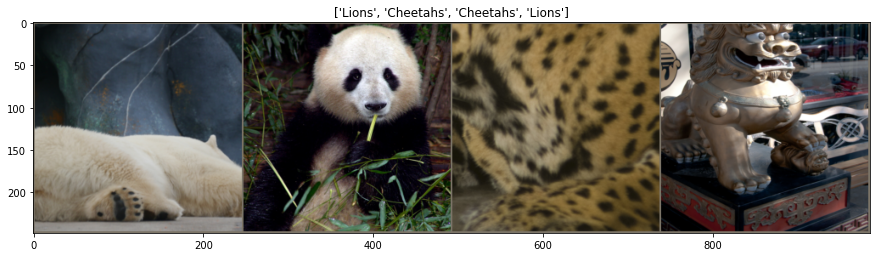

In [5]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.figure(figsize=(15, 12))
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)


# Получим 1 батч (картнки-метки) из обучающей выборки
inputs, classes = next(iter(dataloaders['train']))

# Расположим картинки рядом
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

### Обучение моделей

In [6]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = model.state_dict()
    best_acc = 0.0
    
    #Ваш код здесь
    losses = {'train': [], "val": []}

    pbar = trange(num_epochs, desc="Epoch:")

    for epoch in pbar:

        # каждя эпоха имеет обучающую и тестовую стадии
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train(True)  # установаить модель в режим обучения
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0

            # итерируемся по батчам
            for data in tqdm(dataloaders[phase], leave=False, desc=f"{phase} iter:"):
                # получаем картинки и метки
                inputs, labels = data

                # оборачиваем в переменные
                if use_gpu:
                    inputs = inputs.cuda()
                    labels = labels.cuda()
                else:
                    inputs, labels = inputs, labels

                # инициализируем градиенты параметров
                if phase=="train":
                    optimizer.zero_grad()

                # forward pass
                if phase == "eval":
                    with torch.no_grad():
                        outputs = model(inputs)
                else:
                    outputs = model(inputs)
                preds = torch.argmax(outputs, -1)
                loss = criterion(outputs, labels)

                # backward pass + оптимизируем только если это стадия обучения
                if phase == 'train':
                    loss.backward()
                    optimizer.step()

                # статистика
                running_loss += loss.item()
                running_corrects += int(torch.sum(preds == labels.data))

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects / dataset_sizes[phase]
            
            losses[phase].append(epoch_loss)
            
            pbar.set_description('{} Loss: {:.4f} Acc: {:.4f}'.format(
                                    phase, epoch_loss, epoch_acc
                                ))

            # если достиглось лучшее качество, то запомним веса модели
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = model.state_dict()
            
            scheduler.step()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # загрузим лучшие веса модели
    model.load_state_dict(best_model_wts)
    return model, losses

Функция для измерения точности модели на валидационном датасете

In [7]:
def evaluate(model):
    model.eval()
    
    runninig_correct = 0
    for data in dataloaders['val']:
        # получаем картинки и метки
        inputs, labels = data
        
        # переносим на gpu, если возможно
        if use_gpu:
            inputs = inputs.cuda()
            labels = labels.cuda()
            
        # forard pass
        output = model(inputs)
        _, predicted = torch.max(output, 1)
        
        runninig_correct += int(torch.sum(predicted == labels))
        
    return runninig_correct / dataset_sizes['val']

### Файн Тюнинг ResNet18

In [8]:
model_ft = models.resnet18(weights='IMAGENET1K_V1')
num_ftrs = model_ft.fc.in_features # количество входных фичей в полносвязном слое

model_ft.fc = nn.Linear(num_ftrs, 2) # теперь у нас два класса

if use_gpu:
    model_ft = model_ft.cuda()

criterion = nn.CrossEntropyLoss()

# Оптимизируем все параметры
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Используем лернинг рейт шедулер - каждый 7 эпох домножаем лр на 0.1
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [9]:
model_ft, losses_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=25)

Epoch::   0%|          | 0/25 [00:00<?, ?it/s]

train iter::   0%|          | 0/40 [00:00<?, ?it/s]

val iter::   0%|          | 0/10 [00:00<?, ?it/s]

train iter::   0%|          | 0/40 [00:00<?, ?it/s]

val iter::   0%|          | 0/10 [00:00<?, ?it/s]

train iter::   0%|          | 0/40 [00:00<?, ?it/s]

val iter::   0%|          | 0/10 [00:00<?, ?it/s]

train iter::   0%|          | 0/40 [00:00<?, ?it/s]

val iter::   0%|          | 0/10 [00:00<?, ?it/s]

train iter::   0%|          | 0/40 [00:00<?, ?it/s]

val iter::   0%|          | 0/10 [00:00<?, ?it/s]

train iter::   0%|          | 0/40 [00:00<?, ?it/s]

val iter::   0%|          | 0/10 [00:00<?, ?it/s]

train iter::   0%|          | 0/40 [00:00<?, ?it/s]

val iter::   0%|          | 0/10 [00:00<?, ?it/s]

train iter::   0%|          | 0/40 [00:00<?, ?it/s]

val iter::   0%|          | 0/10 [00:00<?, ?it/s]

train iter::   0%|          | 0/40 [00:00<?, ?it/s]

val iter::   0%|          | 0/10 [00:00<?, ?it/s]

train iter::   0%|          | 0/40 [00:00<?, ?it/s]

val iter::   0%|          | 0/10 [00:00<?, ?it/s]

train iter::   0%|          | 0/40 [00:00<?, ?it/s]

val iter::   0%|          | 0/10 [00:00<?, ?it/s]

train iter::   0%|          | 0/40 [00:00<?, ?it/s]

val iter::   0%|          | 0/10 [00:00<?, ?it/s]

train iter::   0%|          | 0/40 [00:00<?, ?it/s]

val iter::   0%|          | 0/10 [00:00<?, ?it/s]

train iter::   0%|          | 0/40 [00:00<?, ?it/s]

val iter::   0%|          | 0/10 [00:00<?, ?it/s]

train iter::   0%|          | 0/40 [00:00<?, ?it/s]

val iter::   0%|          | 0/10 [00:00<?, ?it/s]

train iter::   0%|          | 0/40 [00:00<?, ?it/s]

val iter::   0%|          | 0/10 [00:00<?, ?it/s]

train iter::   0%|          | 0/40 [00:00<?, ?it/s]

val iter::   0%|          | 0/10 [00:00<?, ?it/s]

train iter::   0%|          | 0/40 [00:00<?, ?it/s]

val iter::   0%|          | 0/10 [00:00<?, ?it/s]

train iter::   0%|          | 0/40 [00:00<?, ?it/s]

val iter::   0%|          | 0/10 [00:00<?, ?it/s]

train iter::   0%|          | 0/40 [00:00<?, ?it/s]

val iter::   0%|          | 0/10 [00:00<?, ?it/s]

train iter::   0%|          | 0/40 [00:00<?, ?it/s]

val iter::   0%|          | 0/10 [00:00<?, ?it/s]

train iter::   0%|          | 0/40 [00:00<?, ?it/s]

val iter::   0%|          | 0/10 [00:00<?, ?it/s]

train iter::   0%|          | 0/40 [00:00<?, ?it/s]

val iter::   0%|          | 0/10 [00:00<?, ?it/s]

train iter::   0%|          | 0/40 [00:00<?, ?it/s]

val iter::   0%|          | 0/10 [00:00<?, ?it/s]

train iter::   0%|          | 0/40 [00:00<?, ?it/s]

val iter::   0%|          | 0/10 [00:00<?, ?it/s]

Training complete in 3m 21s
Best val Acc: 0.925000


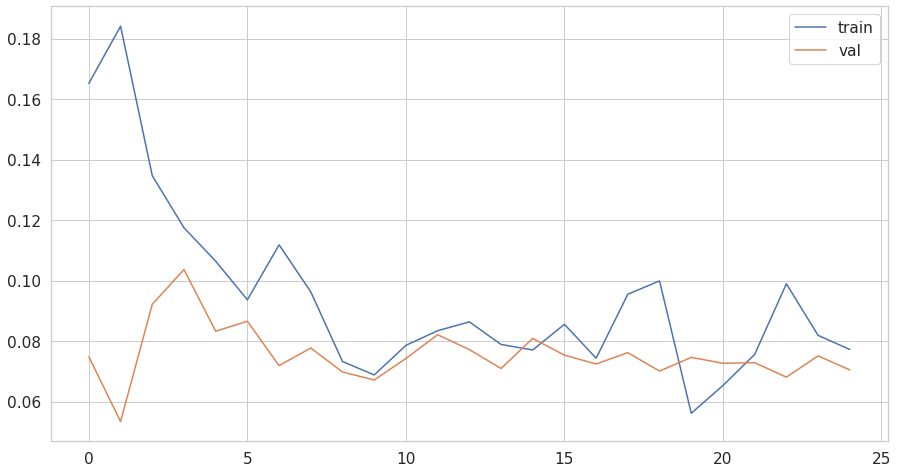

In [10]:
import seaborn as sns

sns.set(style="whitegrid", font_scale=1.4)

# Построим график лосса при обучении и валидации

plt.figure(figsize=(15, 8))
plt.plot(losses_ft['train'], label="train")
plt.plot(losses_ft['val'], label="val")
plt.legend()
plt.show()

Получили accuracy = 0.925

Попробуем второй вариант, когда мы фризим веса у сверточных слоев

In [11]:
model_conv = torchvision.models.resnet18(weights='IMAGENET1K_V1')
for param in model_conv.parameters():
    param.requires_grad = False # фризим веса сверток

num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, 2)

if use_gpu:
    model_conv = model_conv.cuda()

criterion = nn.CrossEntropyLoss()

# оптимизируем параметры только полносвязного слоя
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)

# Используем лернинг рейт шедулер - каждый 7 эпох домножаем лр на 0.1
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

In [12]:
model_conv, losses_conv = train_model(model_conv, criterion, optimizer_conv, exp_lr_scheduler, num_epochs=25)

Epoch::   0%|          | 0/25 [00:00<?, ?it/s]

train iter::   0%|          | 0/40 [00:00<?, ?it/s]

val iter::   0%|          | 0/10 [00:00<?, ?it/s]

train iter::   0%|          | 0/40 [00:00<?, ?it/s]

val iter::   0%|          | 0/10 [00:00<?, ?it/s]

train iter::   0%|          | 0/40 [00:00<?, ?it/s]

val iter::   0%|          | 0/10 [00:00<?, ?it/s]

train iter::   0%|          | 0/40 [00:00<?, ?it/s]

val iter::   0%|          | 0/10 [00:00<?, ?it/s]

train iter::   0%|          | 0/40 [00:00<?, ?it/s]

val iter::   0%|          | 0/10 [00:00<?, ?it/s]

train iter::   0%|          | 0/40 [00:00<?, ?it/s]

val iter::   0%|          | 0/10 [00:00<?, ?it/s]

train iter::   0%|          | 0/40 [00:00<?, ?it/s]

val iter::   0%|          | 0/10 [00:00<?, ?it/s]

train iter::   0%|          | 0/40 [00:00<?, ?it/s]

val iter::   0%|          | 0/10 [00:00<?, ?it/s]

train iter::   0%|          | 0/40 [00:00<?, ?it/s]

val iter::   0%|          | 0/10 [00:00<?, ?it/s]

train iter::   0%|          | 0/40 [00:00<?, ?it/s]

val iter::   0%|          | 0/10 [00:00<?, ?it/s]

train iter::   0%|          | 0/40 [00:00<?, ?it/s]

val iter::   0%|          | 0/10 [00:00<?, ?it/s]

train iter::   0%|          | 0/40 [00:00<?, ?it/s]

val iter::   0%|          | 0/10 [00:00<?, ?it/s]

train iter::   0%|          | 0/40 [00:00<?, ?it/s]

val iter::   0%|          | 0/10 [00:00<?, ?it/s]

train iter::   0%|          | 0/40 [00:00<?, ?it/s]

val iter::   0%|          | 0/10 [00:00<?, ?it/s]

train iter::   0%|          | 0/40 [00:00<?, ?it/s]

val iter::   0%|          | 0/10 [00:00<?, ?it/s]

train iter::   0%|          | 0/40 [00:00<?, ?it/s]

val iter::   0%|          | 0/10 [00:00<?, ?it/s]

train iter::   0%|          | 0/40 [00:00<?, ?it/s]

val iter::   0%|          | 0/10 [00:00<?, ?it/s]

train iter::   0%|          | 0/40 [00:00<?, ?it/s]

val iter::   0%|          | 0/10 [00:00<?, ?it/s]

train iter::   0%|          | 0/40 [00:00<?, ?it/s]

val iter::   0%|          | 0/10 [00:00<?, ?it/s]

train iter::   0%|          | 0/40 [00:00<?, ?it/s]

val iter::   0%|          | 0/10 [00:00<?, ?it/s]

train iter::   0%|          | 0/40 [00:00<?, ?it/s]

val iter::   0%|          | 0/10 [00:00<?, ?it/s]

train iter::   0%|          | 0/40 [00:00<?, ?it/s]

val iter::   0%|          | 0/10 [00:00<?, ?it/s]

train iter::   0%|          | 0/40 [00:00<?, ?it/s]

val iter::   0%|          | 0/10 [00:00<?, ?it/s]

train iter::   0%|          | 0/40 [00:00<?, ?it/s]

val iter::   0%|          | 0/10 [00:00<?, ?it/s]

train iter::   0%|          | 0/40 [00:00<?, ?it/s]

val iter::   0%|          | 0/10 [00:00<?, ?it/s]

Training complete in 2m 43s
Best val Acc: 0.925000


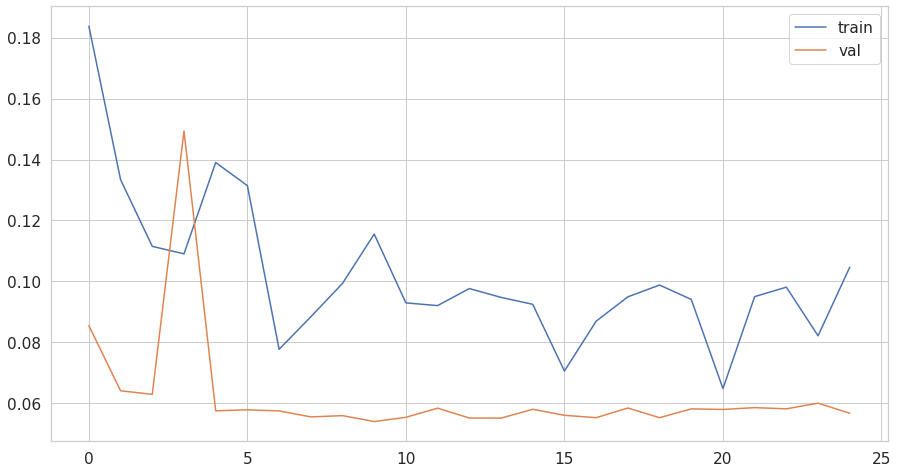

In [13]:
plt.figure(figsize=(15, 8))
plt.plot(losses_conv['train'], label="train")
plt.plot(losses_conv['val'], label="val")
plt.legend()
plt.show()

Получили тоже accuracy = 0.925

### Вывод

В данной работе я файн тюнил предобученные на imagenet'е нейронки для решения задачи классификации - нужно было понять, лев на фотографии или гепард.

Данных было не очень много, поэтому обучать сеть с нуля - неправильно. В работе я попробовал два способа дообучения:
1. дообучаем всю сеть
2. дообучаем только полносвязные слои

В обоих случаях получили accuracy=0.925

В ходе работы я обнаружил проблемы в датасете - помимо львов и гепардов сюда закрались изображения собаки, слона и жирафа. Это могло чуть усложнить задачу для сети